X shape (100, 3)
Estimated slope of the eigenvalue decay: -2.46
R-squared value: 0.97


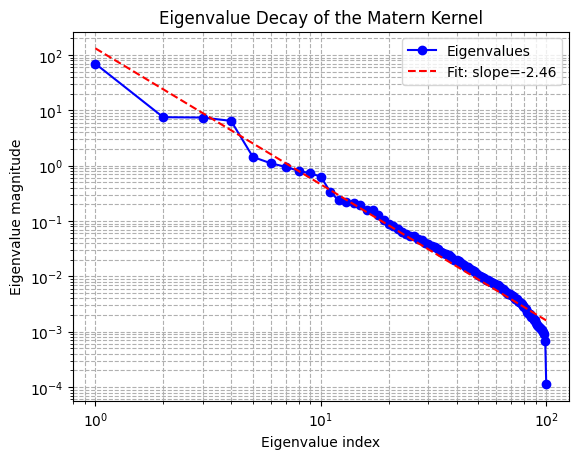

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import linregress

# Parameters
nu = 1.5  # Matern kernel parameter
ell = 1.0  # Length scale
n_points = 100  # Number of points

# Generate random points
X = np.random.rand(n_points, 3)
print('X shape', X.shape)

# Create the Matern kernel
kernel = Matern(nu=nu, length_scale=ell)
K = kernel(X, X)

# Compute the eigenvalues of the kernel matrix
eigenvalues = np.linalg.eigvals(K)

# Sort eigenvalues in descending order
eigenvalues = np.sort(eigenvalues)[::-1]

# Indices of the eigenvalues
indices = np.arange(1, len(eigenvalues) + 1)

# Log-log plot of the eigenvalues
plt.loglog(indices, eigenvalues, 'bo-', label='Eigenvalues')

plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue magnitude')
plt.title('Eigenvalue Decay of the Matern Kernel')

# Fit a line to the log-log plot of eigenvalues
log_indices = np.log(indices)
log_eigenvalues = np.log(eigenvalues)

slope, intercept, r_value, p_value, std_err = linregress(log_indices, log_eigenvalues)

# Plot the fitted line
plt.loglog(indices, np.exp(intercept) * indices**slope, 'r--', label=f'Fit: slope={slope:.2f}')

# Print the slope and R-squared value
print(f"Estimated slope of the eigenvalue decay: {slope:.2f}")
print(f"R-squared value: {r_value**2:.2f}")

lambda_decay = slope  # eigen decay rate, this will be estimated from the plot
# Compute the inverse decay term for each eigenvalue index
#inverse_decay = indices**lambda_decay * eigenvalues[0]
# Add the i^{-lambda} plot
#plt.loglog(indices, inverse_decay, 'g+-', label=f'Polynomial decay', markersize=5)

plt.legend()
plt.grid(True, which="both", ls="--")

# Show the plot
plt.show()

In [41]:
import torch
# inverse problem
# Laplacian operator
# A = 

def f(x, y, z):
    return torch.sin(2 * np.pi * (x + y + z) )
    
def laplacian(f, x, y, z):
    # Ensure inputs require gradients
    x.requires_grad_(True)
    y.requires_grad_(True)
    z.requires_grad_(True)

    # Compute first-order gradients
    f_val = f(x, y, z)
    grad_f_x = torch.autograd.grad(f_val, x, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    grad_f_y = torch.autograd.grad(f_val, y, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    grad_f_z = torch.autograd.grad(f_val, z, grad_outputs=torch.ones_like(z), create_graph=True)[0]

    # Compute second-order gradients
    laplacian_f_x = torch.autograd.grad(grad_f_x, x, grad_outputs=torch.ones_like(grad_f_x), create_graph=True)[0]
    laplacian_f_y = torch.autograd.grad(grad_f_y, y, grad_outputs=torch.ones_like(grad_f_y), create_graph=True)[0]
    laplacian_f_z = torch.autograd.grad(grad_f_z, z, grad_outputs=torch.ones_like(grad_f_z), create_graph=True)[0]

    # Sum second-order derivatives
    laplacian_f = laplacian_f_x + laplacian_f_y + laplacian_f_z

    return laplacian_f

noise = np.random.normal(0, 0.1, n_points)
X_tensor = torch.tensor(X, dtype=torch.float32)
#print(X_tensor.shape)
#laplacian(f, X_tensor.T[0], X_tensor.T[1], X_tensor.T[2]).detach().numpy() + noise
y = f(X_tensor.T[0], X_tensor.T[1], X_tensor.T[2]).detach().numpy() + noise
# y = Af(X) + noise
print('y shape', y.shape)
print(y[:10])
print(noise[:10])

y shape (100,)
[-0.90553625 -0.74306013  0.87386813  0.73244618 -0.46950077  0.97526825
 -0.9910103   1.09005336  0.94977263 -0.04545972]
[-0.09332396  0.1577094  -0.01728801 -0.19952126  0.04528475  0.11793191
 -0.00619369  0.11454312 -0.04316261  0.02540542]


In [42]:
beta = 1
beta_prime = 1

gamma = 10 # regularization parameter
gamma_n = n_points ** (-gamma)
print(gamma_n)
# K.shape # (100, 100)
representer = np.linalg.inv(K + n_points * gamma_n * np.eye(n_points)) @ y
w = np.linalg.solve(K + n_points * gamma_n * np.eye(n_points), y)
print(representer.shape)
print(w.shape)

1e-20
(100,)
(100,)


In [43]:
print(w[:10])
print(representer[:10])

[-41.51556973  63.29217798   4.36369755 -86.47470411 -83.96225273
  49.36399124 -55.01169706  41.4289197   14.92276302   1.68952495]
[-41.51556973  63.29217798   4.36369755 -86.47470411 -83.96225273
  49.36399124 -55.01169706  41.4289197   14.92276302   1.68952495]


In [44]:
# Predict using the kernel trick for test points
X_test = np.random.rand(100, 3)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test = f(X_test_tensor.T[0], X_test_tensor.T[1], X_test_tensor.T[2]).detach().numpy()
K_test = kernel(X_test, X)

print('K_test:', K_test)
print('representer:', representer)
y_pred = np.dot(K_test, representer)
#print(K_test.shape) (10, 100)
#print(representer.shape) （100, 1）
#print(y_pred.shape) (10,)
print(y_test)
print(y_pred)

# Transform the test kernel matrix to match the training kernel
#K_test_train = torch.mm(K_test, K_train)

# Make predictions
#y_pred = torch.mm(K_test_train, f_hat)


K_test: [[0.67393619 0.69411973 0.65490533 ... 0.92490209 0.79805985 0.75530615]
 [0.4486735  0.72838915 0.53789832 ... 0.61899223 0.48753716 0.93092514]
 [0.87181446 0.41251731 0.67742172 ... 0.76501236 0.75539403 0.63457065]
 ...
 [0.53770351 0.5310768  0.41758902 ... 0.68412012 0.78445672 0.60556205]
 [0.79542998 0.57127584 0.79298407 ... 0.8942772  0.73815909 0.76369643]
 [0.47455176 0.83883923 0.50746003 ... 0.8172946  0.6773848  0.54854734]]
representer: [-4.15155697e+01  6.32921780e+01  4.36369755e+00 -8.64747041e+01
 -8.39622527e+01  4.93639912e+01 -5.50116971e+01  4.14289197e+01
  1.49227630e+01  1.68952495e+00  6.39583923e+01 -4.63114252e+01
  2.62344374e+01  5.13007583e+01 -1.32716240e+01  4.10529909e+01
  5.75620414e+01  2.07415047e+01 -2.56129775e-01  3.03612680e+01
 -3.54140092e+01 -1.10373703e+01 -4.98180037e+01  2.44343293e+01
  4.48761979e+01 -4.66525890e+01 -1.97345567e+01  7.86829805e+01
 -2.30130810e+01  6.30675224e+01  2.32476249e+01  3.56573388e+01
 -7.17981035e+0

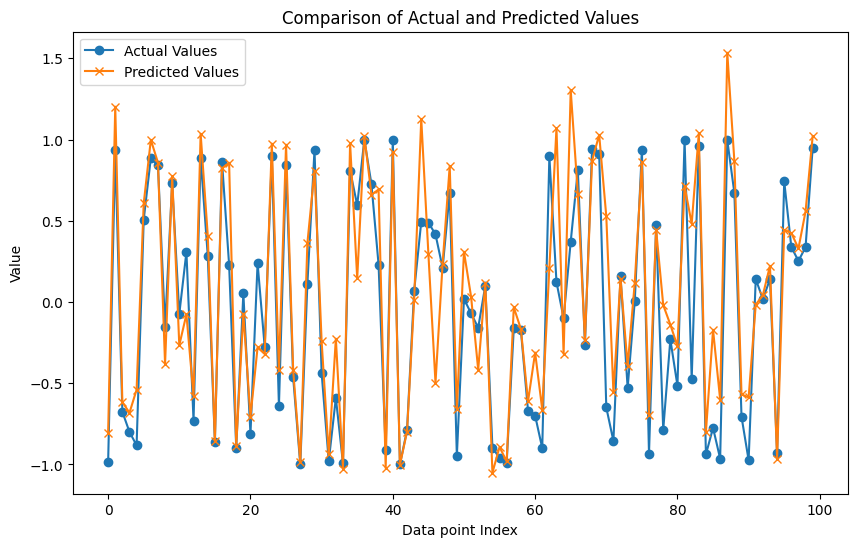

In [45]:
# Plotting the actual and predicted values
plt.figure(figsize=(10, 6))

plt.plot()
# Plot actual values
plt.plot(y_test, label='Actual Values', marker='o')

# Plot predicted values
plt.plot(y_pred, label='Predicted Values', marker='x')

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Data point Index')
plt.ylabel('Value')

# Adding a legend to the plot
plt.legend()

# Show the plot
plt.show()